# PyTorch Neural Network Classification

[Source material](https://www.learnpytorch.io/02_pytorch_classification/)

We'll go through a classification problem using the same workflow covered in pytorch1.ipynb notebook.

In this notebook we're going to cover

1. Architecture of a classification neural network
2. Getting binary classification data ready
3. Building a PyTorch classification model
4. Fitting the model to data
5. Making predictions and ealuating a model
6. Improving a model(from model perspective)
7. Non-linearity
8. Replicating non-linear functions
9. Putting it all together with multi-class classification

## 1. Architecture of a classification neural network

Let's write down the general architecutre of a classification network

* Input layer shape
* Hidden layer(s)
* Neurons per hidden layer
* output layer shape
* Hidden layer activation
* Output activation
* Loss function
* Optimizer

## 2. Make classification data and get it ready

In [3]:
# let's create the data with make_circles
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(
    n_samples,
    noise=0.03,
    random_state=42
)

In [4]:
# Alright let's view the first 5x and y values
print(f"First 5 X features: \n{X[:5]}")
print(f"\nFIrst 5 y labels: \n{y[:5]}")

First 5 X features: 
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

FIrst 5 y labels: 
[1 1 1 1 0]


There's two features and one label per data point. Let's visualize the data.

In [5]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({
    "X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [6]:
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

We have two labels, so it's a binary classification problem and we have a balanced dataset with 500 data points per class.|

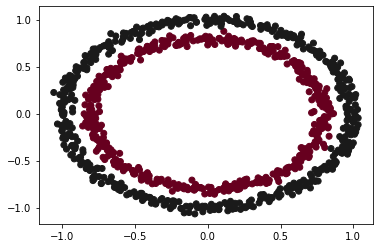

In [7]:
import matplotlib.pyplot as plt
plt.scatter(
    x=X[:, 0],
    y=X[:, 1],
    c=y,
    cmap=plt.cm.RdGy_r
);

## 2. Input and outpupt shapes

One of the most common errors in deep learning is shape errors.

Mismatching shapes of tensors and tensor operations with result in errors in your models.

We're going to see plenty of these throughout the course.

So continuously familiarize ourselves with the shape of data we're working with.

What shapes are my inputs and outputs?

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

In [9]:
# View the first sample of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shape of one sample for x: {X_sample.shape} and y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shape of one sample for x: (2,) and y: ()


So X has two features which is the second dimension of X. we have two inputs per output.

### Turn our data into tensors and create train and test splits

1. Lets convert our data to tensors
2. Split the data into training and test sets

In [10]:
# Turn data into tensors
# Otherwise this will cause issues with computations later on

import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [11]:
# Alright data is in tensors, let's split it into training and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2
)

In [12]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

Good we've 800 training samples and 200 test samples

## Building a model

We've got some data ready, let's build a model.

1. Setting up device agnostic codes(so our model can run on CPU or GPU if it's available)
2. Constructing a model by subclassing nn.Module
3. Defining a loss function and optimizer
4. Creating a training loop

All these steps we've done for a regression problem in pytorch.ipynb notebook

In [13]:
import torch
from torch import nn

# Make device agnostice code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Let's create the model class that:

1. Subclasses `nn.Module` ( almost all PyTorch models are subclasses of nn.Module)
2. Creates 2 `nn.Linear` layers in the constructor capable of handling the input and output shapes of X and y
3. Defines a `forward()` method containing the forward pass computation of the model
4. Instantiate the model class and sends it to the target `device`

In [14]:
# Construce a model class
class CircleModelV0(nn.Module):

    def __init__(self):
        super().__init__()

        # Create 2 nn.Linear layers capable of handling X and y input and output shape
        self.layer_1 = nn.Linear(
            in_features=2,
            out_features=5
        )
        self.layer_2 = nn.Linear(
            in_features=5,
            out_features=1
        )

    def forward(self, x):
        return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

What's going on here?

The major change is `self.layer_1` takes two input features and produces 5 output features.

This is known as having **hidden units** or neurons.

This layer accepts two input features and converts it to 5 features.

Why do this? This allows model to learn patterns from 5 numbers rather than just 3 number, potentially leading to better outputs. Potentially because sometimes it won't work so hidden  neurons is an hyper parameter that can be tweaked with respect to model or dataset.

Generally more is better but there's also such thing as too much.

The only rule with hidden units is the next layer, in our case `self.layer_2` accepts same number of input features as the previous layers output features.

We can also build the same model using `nn.Sequential` it performs a forward pass computation of the input data through the layers in the order they appear.

In [15]:
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

We can use this for Sequential computation but for other functionalites we'll subclaass nn.Module to create our owm computation flow.

In [16]:
# Make prediction with model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions: \n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels: \n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions: 
tensor([[-0.0501],
        [ 0.2230],
        [ 0.1860],
        [-0.0613],
        [ 0.0386],
        [-0.0504],
        [ 0.1236],
        [ 0.0777],
        [ 0.0707],
        [ 0.0591]], grad_fn=<SliceBackward0>)

First 10 test labels: 
tensor([1., 0., 1., 0., 0., 1., 0., 1., 0., 0.])


In [17]:
untrained_preds[0], y_test[0]

(tensor([-0.0501], grad_fn=<SelectBackward0>), tensor(1.))

Hmm the shapes of predictions and y_labels are not the same, we'll  fix these later on.

### Setup loss function and optimizer

> **Note**📄: Recall a loss function is what measure how wrong the model predictions are, the higher the loss, wore the model.

PyTorch has two binary cross entropy implementations:

1. `torch.nn.BCELoss()` - Creates a loss function that measurres the binary cross entropy between the target(label) and input(featurees).

2. `torch.nn.BCEWithLogitsLoss()` - This is same as above except it has a sigmoid layer(nn.sigmoid)

We can use any optmizer from `torch.optim`

In [18]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(
    params=model_0.parameters(),
    lr=0.01
)

Now let's also create an **evlaution metric**

An evaluation metric can be used to offer another perspective on how the model is going.

If a loss function measures how wrong the model is, think of evaluation metric as measuring how right it is.

After all evaluating tht models with multiple points of view.

Let's start with accuracy,

Accuracy can be measured by dividing the total number of orrect predictions over the total number of predictions. 

In [19]:
# Let's write a functio to do this
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(
        y_true, y_pred
    ).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## Train model

Let's remember the steps in PyTorch Training loop

1. Forward pass
2. Calculate loss
3. Zero gradients
4. Backpropogation on loss
5. Step the optimizer

### Going from raw model outputs to predicted labels(logits -> prediction probabalities -> prediction labels)

Before training loop steps, let's see what comes out of our model during the forward pass(`forward()` method)

In [20]:
# View the first 5 outputs of the forward pass
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0501],
        [ 0.2230],
        [ 0.1860],
        [-0.0613],
        [ 0.0386]], grad_fn=<SliceBackward0>)

What are these outputs, since our model is not trained the output is random guess by the model.

But what it does is inputs are passed through `nn.Linear()` layers which internally multiplier inputs with trainspose of weights plus bias.

The raw outputs of our model are often referred to as logits.

However these numbers ae hard to interpret, we'd like some numbers that are comparable to our truth labels.

In such case we can use the sigmoid activation function.

In [21]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4875],
        [0.5555],
        [0.5464],
        [0.4847],
        [0.5096]], grad_fn=<SigmoidBackward0>)

Now the outputs in the form of **Prediction probabalities**, in other words, the values are how much the model thinks the data point belongs to one class or another.

More specifically:

* if `y_pred_probs` >= 0.5, y=1
* `y_pred_probs` < 0.5, y=0

In [22]:
# Find the predicted labels(round the prediction probablities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(
    model_0(X_test.to(device)[:5])
))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 1., 1., 0., 1.], grad_fn=<SqueezeBackward0>)

Exellent! Now our models's prediction are in the same form as our truth labels:

In [23]:
y_test[:5]

tensor([1., 0., 1., 0., 0.])

### Building a training and testing loop

In [24]:
torch.manual_seed(42)

# Number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

model_1 = CircleModelV0().to(device)

# Build training and evaluation loop
for epoch in range(epochs):

    ### Training 
    model_1.train()

    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Zero grad
    optimizer.zero_grad()

    # 4. Backpropogation
    loss.backward()

    # 5. optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()

    # 1. Inference mode
    with torch.inference_mode():

        # 2. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 3. Calculate loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69693, Accuracy: 49.88% | Test loss: 0.69244, Test acc: 50.50%
Epoch: 10 | Loss: 0.69693, Accuracy: 49.88% | Test loss: 0.69244, Test acc: 50.50%
Epoch: 20 | Loss: 0.69693, Accuracy: 49.88% | Test loss: 0.69244, Test acc: 50.50%
Epoch: 30 | Loss: 0.69693, Accuracy: 49.88% | Test loss: 0.69244, Test acc: 50.50%
Epoch: 40 | Loss: 0.69693, Accuracy: 49.88% | Test loss: 0.69244, Test acc: 50.50%
Epoch: 50 | Loss: 0.69693, Accuracy: 49.88% | Test loss: 0.69244, Test acc: 50.50%
Epoch: 60 | Loss: 0.69693, Accuracy: 49.88% | Test loss: 0.69244, Test acc: 50.50%
Epoch: 70 | Loss: 0.69693, Accuracy: 49.88% | Test loss: 0.69244, Test acc: 50.50%
Epoch: 80 | Loss: 0.69693, Accuracy: 49.88% | Test loss: 0.69244, Test acc: 50.50%
Epoch: 90 | Loss: 0.69693, Accuracy: 49.88% | Test loss: 0.69244, Test acc: 50.50%


Hmm, There's no improvement in the performance of our model across epochs, it's accuracy is actually guessing the class.

## Make predictions and evaluate the model

In [25]:
# Let's write a funtion to plot predictions
def plot_predictions(
    train_data,
    train_labels,
    test_data,
    test_labels,
    predictions=None,
):
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the preictions in red
        plt.scatter(test_data, predictions, c="r", s=4, label="Predicions")

    # Show the legend
    plt.legend(prop={"size": 14})


In [26]:
import numpy as np
def plot_decision_boundary(
    model: torch.nn.Module,
    X: torch.Tensor,
    y: torch.Tensor
):
    # Put everything to CPU(works better with NumpY + Matplotlib)
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    X_min, X_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(
        np.linspace(X_min, X_max, 101),
        np.linspace(y_min, y_max, 101)
    )

    # Make features
    X_to_pred_on = torch.from_numpy(
        np.column_stack(
            (xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contour(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

Alright we've the functions, let's plot decision boundaries

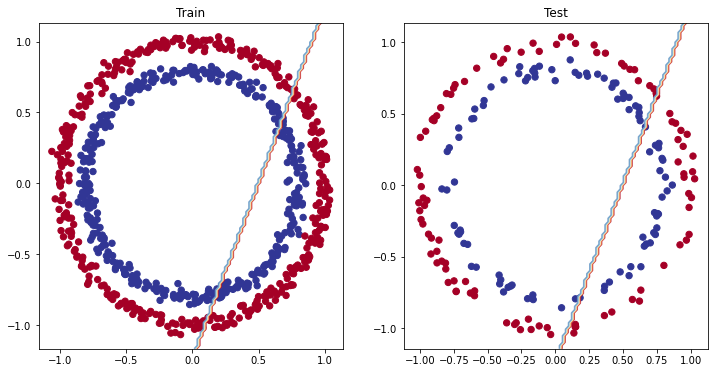

In [27]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

Oh this is the cause of model's performance issue. 

Model's trying to split the red and blue dots using a straight line...

That explains the 50% accuracy. since our data is circular.drawing a straight line can at best cut it down the middle.

## Improving a model (from a model perspective)

Model improvement technique

1. Add more layers (deeper)
2. Add more hidden units (wider)
3. Fitting for longer(more epochs)
4. Changing the activation functions
5. Changing the learning rate
6. Change the loss function
7. Use transfer learning

> **Note**📄: because all these can be adjuste by hand these are referred to as hyperparameters. 

Let's see what happens if we add an extra layer to our model, fir for longer and increase the number of hidden units

In [28]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(
            in_features=2,
            out_features=10
        )
        self.layer_2 = nn.Linear(
            in_features=10,
            out_features=10
        )
        self.layer_3 = nn.Linear(
            in_features=10,
            out_features=1
        )


    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_2 = CircleModelV1().to(device)
model_2

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

Now we've got a model, we'll recreate a loss function and optimizer instance, using the same settings as before.

In [29]:
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [30]:
model_2.parameters

<bound method Module.parameters of CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)>

Beautiful, model, optimizer and loss function ready, let's make a training loop.

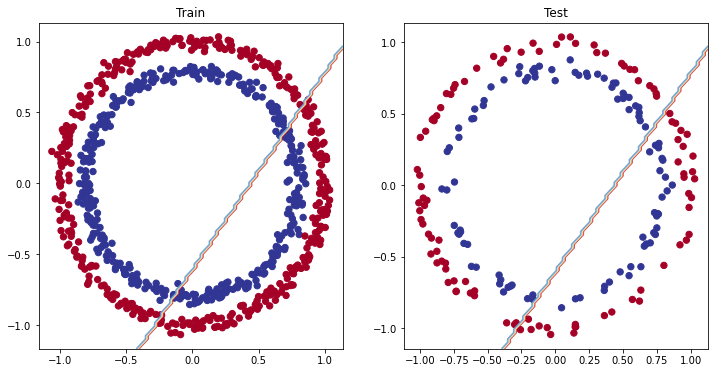

In [31]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)

Our model is still drawing a straight line between the reds and blue dots.

If our model is drawing a straight line, coult it model linear data?

## Preparing data to see if our model can model a straight line

Let's create some linear data to see if our model's able to model it and we're not just using a model that can't learn anything.

In [32]:
# Create some data
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [33]:
# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(
    len(X_train_regression),
    len(y_train_regression),
    len(X_test_regression),
    len(y_test_regression)
)

80 80 20 20


Let see how the data looks

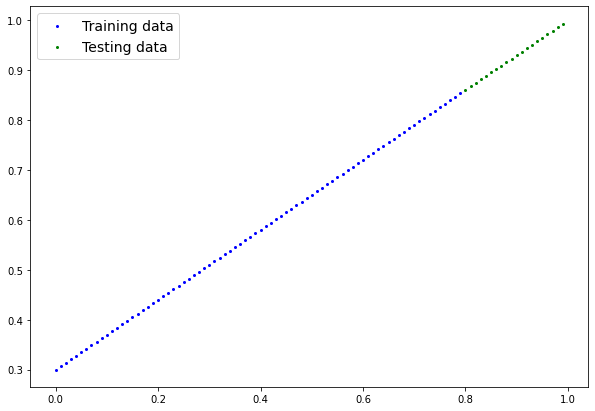

In [34]:
plot_predictions(
    train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression 
)

### Adjusting `model_2` to fit a straight line

In [35]:
# Same architecture as model_1 (but using sequential)
model_3 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_3

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

Setting up loass and optimizer

In [36]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

Writing trainign loop again

In [37]:
# Train the model
torch.manual_seed(42)

# Set number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_pred = model_3(X_train_regression)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train_regression)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()

    with torch.inference_mode():
        # 1. Forward pass
        test_pred = model_3(X_test_regression)

        # 2. Loss
        test_loss = loss_fn(test_pred, y_test_regression)

    # Print what's happening
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch 0 | Loss: 0.78361, Accuracy: 49.88% | Test loss: 0.78401, Test acc: 50.50%
Epoch 100 | Loss: 0.07665, Accuracy: 49.88% | Test loss: 0.22803, Test acc: 50.50%
Epoch 200 | Loss: 0.05887, Accuracy: 49.88% | Test loss: 0.16330, Test acc: 50.50%
Epoch 300 | Loss: 0.05653, Accuracy: 49.88% | Test loss: 0.14826, Test acc: 50.50%
Epoch 400 | Loss: 0.05992, Accuracy: 49.88% | Test loss: 0.14861, Test acc: 50.50%
Epoch 500 | Loss: 0.05909, Accuracy: 49.88% | Test loss: 0.14233, Test acc: 50.50%
Epoch 600 | Loss: 0.05609, Accuracy: 49.88% | Test loss: 0.12893, Test acc: 50.50%
Epoch 700 | Loss: 0.05452, Accuracy: 49.88% | Test loss: 0.13845, Test acc: 50.50%
Epoch 800 | Loss: 0.05308, Accuracy: 49.88% | Test loss: 0.13114, Test acc: 50.50%
Epoch 900 | Loss: 0.05161, Accuracy: 49.88% | Test loss: 0.11803, Test acc: 50.50%


Okay unlike `model_2` on the classification data `model_3` loss is actually going down.

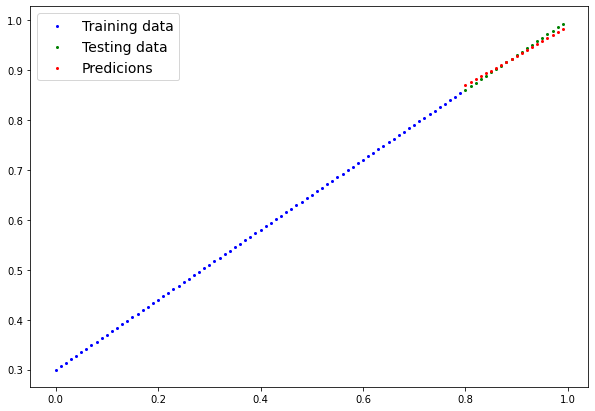

In [38]:
# Turn on evaluation model
model_3.eval()

# Make predictions
with torch.inference_mode():
    y_preds = model_3(X_test_regression)

plot_predictions(
    train_data=X_train_regression.cpu(),
    train_labels=y_train_regression.cpu(),
    test_data=X_test_regression.cpu(),
    test_labels=y_test_regression.cpu(),
    predictions=y_preds.cpu()
)

So what's missing why it's not working on classification data that looks like circles...

## The missing piece: non-linearity

The model can drae straight lines, 

let's give the model capacity to draw non-straight(non-linear) lines?

### Recreating non-linear data (red and blue circles)

First let's recreate the data to start off fresh. We'll use the same setup as before.

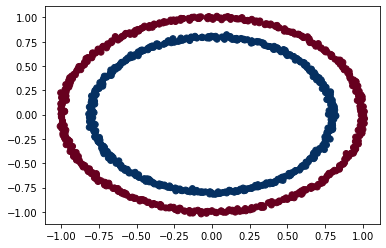

In [39]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000
X, y = make_circles(
    n_samples=1000,
    noise=0.01,
    random_state=42
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

### Splitting data into training and test sets using 80% for training and 20% testing.

In [40]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train[:5], y_train[:5]

(tensor([[ 0.6387, -0.4846],
         [ 0.6609, -0.7366],
         [-0.9953, -0.1415],
         [-0.9719, -0.2247],
         [-0.1686,  0.7877]]),
 tensor([1., 0., 0., 0., 1.]))

### Building a model with non-linearity

In [41]:
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [42]:
model_4 = CircleModelV2().to(device)
print(model_4)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [43]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

### Training a model with non-linearity

In [44]:
# Fit the model
torch.manual_seed(42)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

# Training loop
for epoch in range(epochs):
    ### Training 
    # 1. Forward pass
    y_logits = model_4(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Loss/accuracy
    loss = loss_fn(y_logits, y_train)
    accuracy = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()

    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_4(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        # 2. Loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")  

Epoch 0 | Loss: 0.69295, Accuracy: 49.88% | Test loss: 0.69307, Test acc: 50.00%
Epoch 100 | Loss: 0.69117, Accuracy: 49.88% | Test loss: 0.69081, Test acc: 53.00%
Epoch 200 | Loss: 0.68983, Accuracy: 49.88% | Test loss: 0.68907, Test acc: 55.50%
Epoch 300 | Loss: 0.68803, Accuracy: 49.88% | Test loss: 0.68674, Test acc: 56.50%
Epoch 400 | Loss: 0.68521, Accuracy: 49.88% | Test loss: 0.68336, Test acc: 56.50%
Epoch 500 | Loss: 0.68117, Accuracy: 49.88% | Test loss: 0.67822, Test acc: 56.50%
Epoch 600 | Loss: 0.67532, Accuracy: 49.88% | Test loss: 0.67110, Test acc: 57.50%
Epoch 700 | Loss: 0.66659, Accuracy: 49.88% | Test loss: 0.66043, Test acc: 61.00%
Epoch 800 | Loss: 0.65164, Accuracy: 49.88% | Test loss: 0.64386, Test acc: 69.50%
Epoch 900 | Loss: 0.62356, Accuracy: 49.88% | Test loss: 0.61609, Test acc: 78.00%


### Evalutaing a model trained with non-linear activation functions

In [45]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_4(X_test))).squeeze()
y_preds[:10], y[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

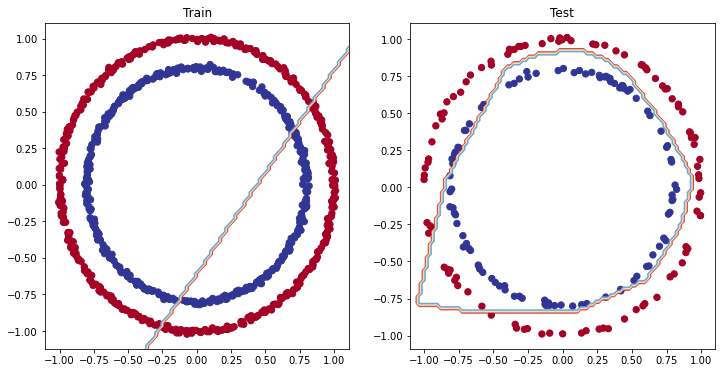

In [46]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train) # model_2 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_test, y_test) # model_4 with non-linearity

Nice after giving model the capacity of non-linearity, the model's been able to make some sort of unstraight line with circles.

## Replicatin non-linear activation functions

Let's see how non-linear activation look like?

How about we replicate some and what they do?

Let's start by creating a small amount of data.

In [47]:
# Create a toy tensor(similar to the data going into our model(s))
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

Let's plot these.

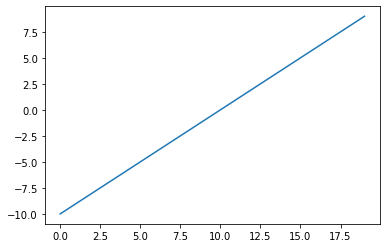

In [48]:
plt.plot(A)

A straight line, let's see how the ReLu activation function influences it.

ReLu function turns all negatives to 0 and leaves the positive values as they are.

In [49]:
def relu(x):
    return torch.maximum(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

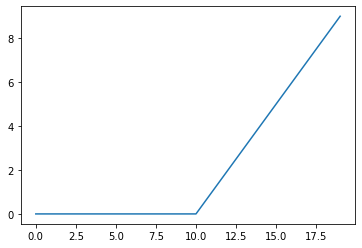

In [50]:
plt.plot(relu(A))

In [51]:
# Let's try out the sigmoid
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

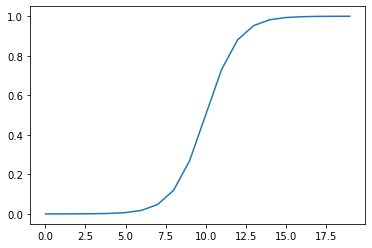

In [52]:
plt.plot(sigmoid(A))

## Creating multi-class classification data

Let's create multi-classification data using Scikit-Learn's make_blobs() method.

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


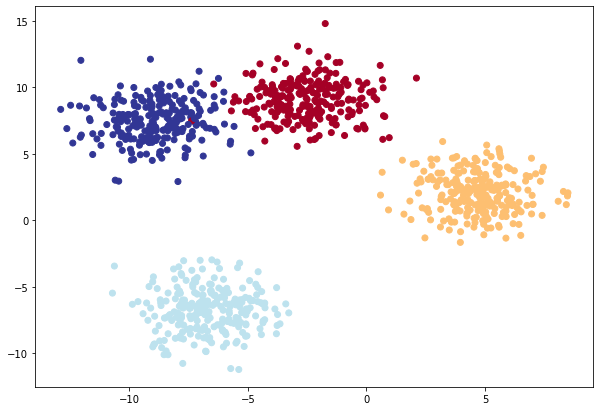

In [196]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi class data
X_blob, y_blob = make_blobs(
    n_samples=1000,
    n_features = NUM_FEATURES,
    centers=NUM_CLASSES,
    cluster_std=1.5,
    random_state=42
)

# 2. Turn data into tensots
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [197]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Creating a multi class classification model

In [201]:
from turtle import forward
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units):
        """
        Intializes all required hyperparamters for a multiclass classification module

        Args:
            input_features (int): Number of in features to the model
            output_features (int): Number of out features to the model
            hidden_units (int): Number of hidden units per hidden layer
        """
        super().__init__()

        self.linear_layer_stack = nn.Sequential(
            nn.Linear(
                in_features=input_features,
                out_features=hidden_units
            ),
            # nn.ReLU(),
            nn.Linear(
                in_features=hidden_units,
                out_features=hidden_units
            ),
            # nn.ReLU(),
            nn.Linear(
                in_features=hidden_units,
                out_features=output_features
            )
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

model_5 = BlobModel(
    input_features=NUM_FEATURES,
    output_features=NUM_CLASSES,
    hidden_units=8
).to(device)
model_5

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

### Creating a loss function and optimizer

In [207]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model_5.parameters(),
    lr=0.1
)

### Creating a train test loop

In [208]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_5.train()

    # 1. Forward pass
    y_logits = model_5(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_5.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_5(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.04324, Acc: 65.50% | Test Loss: 0.57861, Test Acc: 95.50%
Epoch: 10 | Loss: 0.14398, Acc: 99.12% | Test Loss: 0.13037, Test Acc: 99.00%
Epoch: 20 | Loss: 0.08062, Acc: 99.12% | Test Loss: 0.07216, Test Acc: 99.50%
Epoch: 30 | Loss: 0.05924, Acc: 99.12% | Test Loss: 0.05133, Test Acc: 99.50%
Epoch: 40 | Loss: 0.04892, Acc: 99.00% | Test Loss: 0.04098, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04295, Acc: 99.00% | Test Loss: 0.03486, Test Acc: 99.50%
Epoch: 60 | Loss: 0.03910, Acc: 99.00% | Test Loss: 0.03083, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03643, Acc: 99.00% | Test Loss: 0.02799, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03448, Acc: 99.00% | Test Loss: 0.02587, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03300, Acc: 99.12% | Test Loss: 0.02423, Test Acc: 99.50%


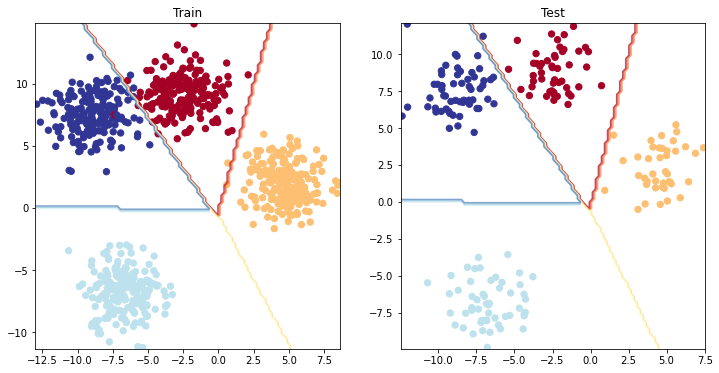

In [209]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_5, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_5, X_blob_test, y_blob_test)

In [215]:
# Make predictions
model_5.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  4.3377,  10.3539, -14.8948,  -9.7642],
        [  5.0142, -12.0371,   3.3860,  10.6699],
        [ -5.5885, -13.3448,  20.9894,  12.7711],
        [  1.8400,   7.5599,  -8.6016,  -6.9942],
        [  8.0727,   3.2906, -14.5998,  -3.6186],
        [  5.5844, -14.9521,   5.0168,  13.2891],
        [ -5.9739, -10.1913,  18.8655,   9.9179],
        [  7.0755,  -0.7601,  -9.5531,   0.1736],
        [ -5.5918, -18.5990,  25.5310,  17.5799],
        [  7.3142,   0.7197, -11.2017,  -1.2011]])

In [216]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 99.5%


In [217]:
!pip -q install torchmetrics

from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy().to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9950)